In [1]:
import pandas as pd
from scipy.stats import ttest_rel

# --- Load pseudobulk results --- #
def load_pseudobulk_results(path, model_prefix):
    df = pd.read_csv(path)[["DRUG_ID", "r2_global", "pearson_r", "rmse"]]
    return df.rename(columns={
        "r2_global": f"R2_{model_prefix}_pseudobulk",
        "pearson_r": f"Pearson_{model_prefix}_pseudobulk",
        "rmse": f"RMSE_{model_prefix}_pseudobulk"
    })

enet_pb = load_pseudobulk_results("01_simple_baselines/results/elastic_net/10_fold_pseudobulk_30_pcs_tissue_growth.csv", "EN")
rf_pb   = load_pseudobulk_results("02_complex_baselines/results/rf/10_fold_pseudobulk_30_pcs_tissue_growth.csv", "RF")
xgb_pb  = load_pseudobulk_results("02_complex_baselines/results/xgboost/10_fold_pseudobulk_30_pcs_tissue_growth.csv", "XGB")

# --- Reuse scGPT loading functions from earlier --- #
def load_scgpt_results(path, model_prefix):
    df = pd.read_csv(path)[["DRUG_ID", "r2_global", "pearson_r", "rmse"]]
    return df.rename(columns={
        "r2_global": f"R2_{model_prefix}_scgpt",
        "pearson_r": f"Pearson_{model_prefix}_scgpt",
        "rmse": f"RMSE_{model_prefix}_scgpt"
    })

enet_gpt = load_scgpt_results("01_simple_baselines/results/elastic_net/scgpt_10_fold_embeddings_30_pcs_tissue_growth.csv", "EN")
rf_gpt   = load_scgpt_results("02_complex_baselines/results/rf/scgpt_10_fold_embeddings_30_pcs_tissue_growth.csv", "RF")
xgb_gpt  = load_scgpt_results("02_complex_baselines/results/xgboost/scgpt_10_fold_embeddings_30_pcs_tissue_growth.csv", "XGB")

# --- Merge by DRUG_ID --- #
def merge_embeddings(df1, df2):
    return df1.merge(df2, on="DRUG_ID", how="inner")

enet_merged = merge_embeddings(enet_pb, enet_gpt)
rf_merged   = merge_embeddings(rf_pb, rf_gpt)
xgb_merged  = merge_embeddings(xgb_pb, xgb_gpt)

# --- Paired t-tests --- #
def run_comparison(df, model_name):
    print(f"\n🔍 Comparing Pseudobulk vs. scGPT for {model_name}:")
    for metric in ["R2", "Pearson", "RMSE"]:
        col_pb = f"{metric}_{model_name}_pseudobulk"
        col_gpt = f"{metric}_{model_name}_scgpt"

        # Flip RMSE sign so higher = better
        if metric == "RMSE":
            df[col_pb] = -df[col_pb]
            df[col_gpt] = -df[col_gpt]

        t_stat, p_val = ttest_rel(df[col_pb], df[col_gpt])
        print(f"{metric}: t = {t_stat:.3f}, p = {p_val:.3e}")

# --- Metric summaries --- #
def summarize_differences(df, model_name):
    print(f"\n📊 Mean Metrics for {model_name} (Pseudobulk vs scGPT):")
    for metric in ["R2", "Pearson", "RMSE"]:
        col_pb = f"{metric}_{model_name}_pseudobulk"
        col_gpt = f"{metric}_{model_name}_scgpt"

        mean_pb = df[col_pb].mean()
        mean_gpt = df[col_gpt].mean()
        print(f"{metric}:")
        print(f"  Pseudobulk : {mean_pb:.4f}")
        print(f"  scGPT      : {mean_gpt:.4f}")
        print(f"  Δ (GPT - Pseudobulk): {mean_gpt - mean_pb:.4f}")

        # Count per-drug improvement
        if metric == "RMSE":
            improved = (df[col_gpt] < df[col_pb]).sum()
            worsened = (df[col_gpt] > df[col_pb]).sum()
        else:
            improved = (df[col_gpt] > df[col_pb]).sum()
            worsened = (df[col_gpt] < df[col_pb]).sum()

        print(f"  ↑ Improved drugs: {improved}")
        print(f"  ↓ Worsened drugs: {worsened}")

# --- Run for each model --- #
for df, model in [(enet_merged, "EN"), (rf_merged, "RF"), (xgb_merged, "XGB")]:
    run_comparison(df, model)
    summarize_differences(df, model)



🔍 Comparing Pseudobulk vs. scGPT for EN:
R2: t = 2.778, p = 5.641e-03
Pearson: t = 2.292, p = 2.224e-02
RMSE: t = 2.018, p = 4.405e-02

📊 Mean Metrics for EN (Pseudobulk vs scGPT):
R2:
  Pseudobulk : 0.0732
  scGPT      : 0.0662
  Δ (GPT - Pseudobulk): -0.0070
  ↑ Improved drugs: 291
  ↓ Worsened drugs: 332
Pearson:
  Pseudobulk : 0.2244
  scGPT      : 0.2136
  Δ (GPT - Pseudobulk): -0.0108
  ↑ Improved drugs: 295
  ↓ Worsened drugs: 328
RMSE:
  Pseudobulk : -1.1858
  scGPT      : -1.1893
  Δ (GPT - Pseudobulk): -0.0035
  ↑ Improved drugs: 332
  ↓ Worsened drugs: 291

🔍 Comparing Pseudobulk vs. scGPT for RF:
R2: t = 7.491, p = 2.350e-13
Pearson: t = 4.670, p = 3.687e-06
RMSE: t = 7.274, p = 1.051e-12

📊 Mean Metrics for RF (Pseudobulk vs scGPT):
R2:
  Pseudobulk : 0.0637
  scGPT      : 0.0433
  Δ (GPT - Pseudobulk): -0.0204
  ↑ Improved drugs: 232
  ↓ Worsened drugs: 393
Pearson:
  Pseudobulk : 0.2599
  scGPT      : 0.2424
  Δ (GPT - Pseudobulk): -0.0175
  ↑ Improved drugs: 255
  ↓ Wo

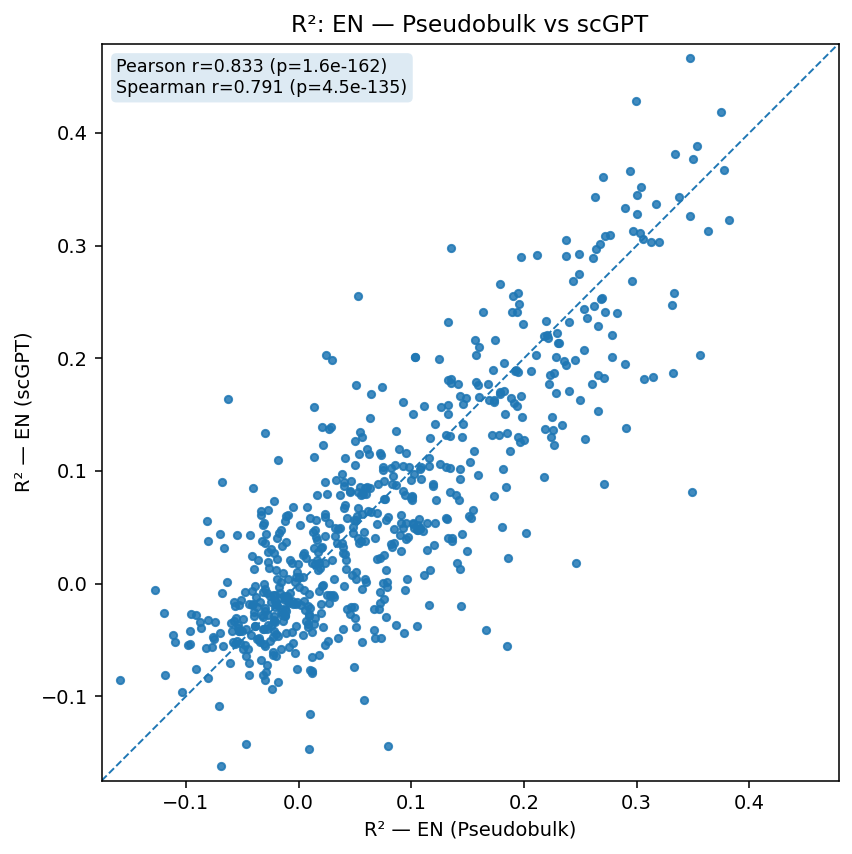

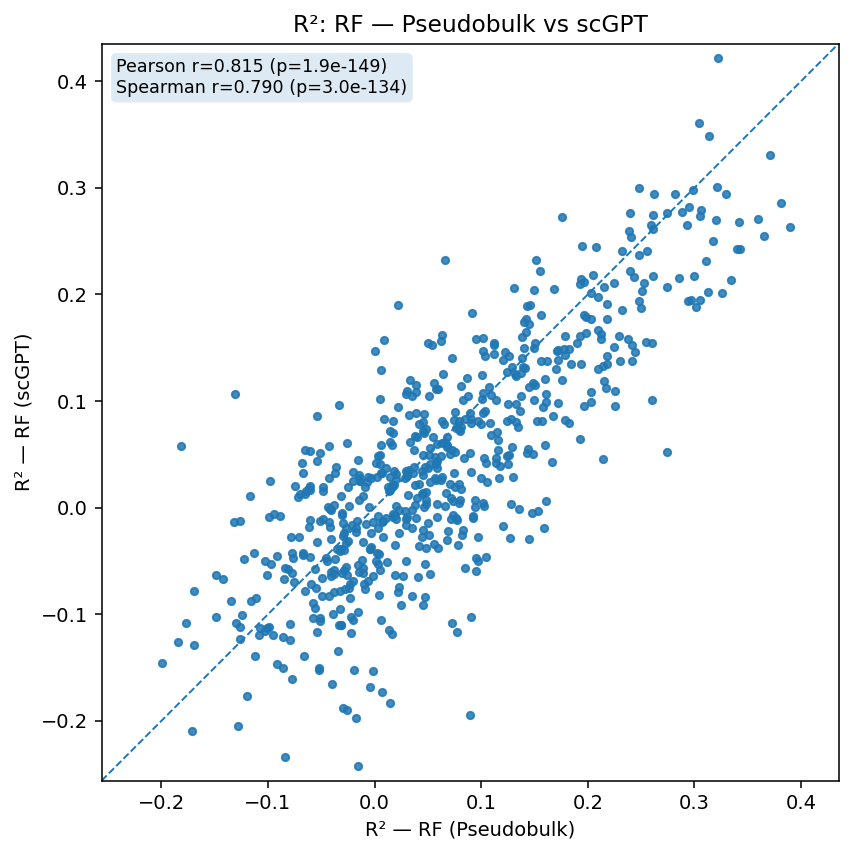

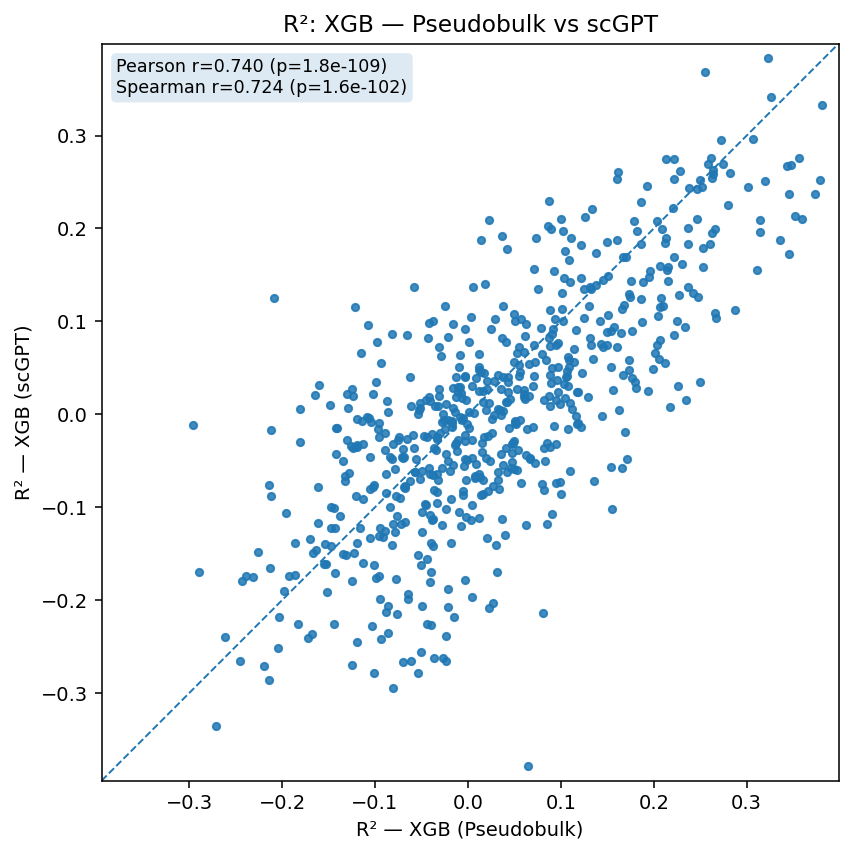

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

def plot_r2_vs_r2(df, col_x, col_y, label_x, label_y, drug_col="DRUG_ID",
                  annotate_top=12, title=None):
    """
    Scatter of per-drug R² with a 45° parity line and Pearson/Spearman stats.
    NOTE: 'annotate_top' is kept for backward compatibility but is ignored.
    """
    # Pull data
    x = df[col_x].to_numpy()
    y = df[col_y].to_numpy()

    # Figure
    fig, ax = plt.subplots(figsize=(6.2,6.2), dpi=140)
    ax.scatter(x, y, s=14, alpha=0.85)

    # Parity line
    mn = np.nanmin([np.nanmin(x), np.nanmin(y)])
    mx = np.nanmax([np.nanmax(x), np.nanmax(y)])
    pad = 0.02 * (mx - mn if mx > mn else 1.0)
    ax.plot([mn - pad, mx + pad], [mn - pad, mx + pad], ls="--", lw=1)

    # Correlations box
    pr, pp = pearsonr(x, y)
    sr, sp = spearmanr(x, y)
    txt = f"Pearson r={pr:.3f} (p={pp:.1e})\nSpearman r={sr:.3f} (p={sp:.1e})"
    ax.text(0.02, 0.98, txt, transform=ax.transAxes, va="top", ha="left",
            fontsize=9, bbox=dict(boxstyle="round", alpha=0.15, ec="none"))

    # Axes, title, aspect
    ax.set_xlabel(f"R² — {label_x}")
    ax.set_ylabel(f"R² — {label_y}")
    ax.set_title(title or f"Per-drug R²: {label_x} vs {label_y}")
    ax.set_xlim(mn - pad, mx + pad)
    ax.set_ylim(mn - pad, mx + pad)
    ax.set_aspect("equal", adjustable="box")
    plt.tight_layout()
    plt.show()
    # EN: Pseudobulk vs scGPT
plot_r2_vs_r2(enet_merged,
              col_x="R2_EN_pseudobulk", col_y="R2_EN_scgpt",
              label_x="EN (Pseudobulk)", label_y="EN (scGPT)",
              annotate_top=12, title="R²: EN — Pseudobulk vs scGPT")

# RF
plot_r2_vs_r2(rf_merged,
              col_x="R2_RF_pseudobulk", col_y="R2_RF_scgpt",
              label_x="RF (Pseudobulk)", label_y="RF (scGPT)",
              annotate_top=12, title="R²: RF — Pseudobulk vs scGPT")

# XGB
plot_r2_vs_r2(xgb_merged,
              col_x="R2_XGB_pseudobulk", col_y="R2_XGB_scgpt",
              label_x="XGB (Pseudobulk)", label_y="XGB (scGPT)",
              annotate_top=12, title="R²: XGB — Pseudobulk vs scGPT")
